# Loading any xarray-DataSet (not only qcodes-exported) into QCoDeS database with raw data

This notebook demonstrates how one can import an xarray DataSet, not necessarily exported with QCoDeS from a QCoDeS DataSet, into a QCoDeS database in such a way that the raw data gets added to the database as well.

## Setup

First, we borrow an example from the measurement notebook to have some data to work with.

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr

import qcodes as qc
from qcodes.dataset import (
    initialise_or_create_database_at,
    load_or_create_experiment,
    Measurement,
)
from qcodes.tests.instrument_mocks import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)
from qcodes.dataset.plotting import plot_dataset

qc.logger.start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\miastafe\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\miastafe\.qcodes\logs\211129-29276-qcodes.log
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\miastafe\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\miastafe\.qcodes\logs\211129-29276-qcodes.log


In [2]:
# preparatory mocking of physical setup
dac = DummyInstrument("dac", gates=["ch1", "ch2"])
dmm = DummyInstrumentWithMeasurement("dmm", setter_instr=dac)
station = qc.Station(dmm, dac)

In [3]:
initialise_or_create_database_at("./export_example.db")
exp = load_or_create_experiment(
    experiment_name="exporting_data", sample_name="no sample"
)

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 499.62it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 333.20it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 499.62it/s]


In [4]:
meas = Measurement(exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dac.ch2)  # register the second independent parameter
meas.register_parameter(
    dmm.v2, setpoints=(dac.ch1, dac.ch2)
)  # register the dependent one

We then perform two very basic measurements using dummy instruments.

In [5]:
# run a 2D sweep

with meas.run() as datasaver:

    for v1 in np.linspace(-1, 0, 200, endpoint=False):
        for v2 in np.linspace(-1, 1, 201):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1), (dac.ch2, v2), (dmm.v2, val))

qc_dataset = datasaver.dataset

Starting experimental run with id: 1. 


([<AxesSubplot:title={'center':'Run #1, Experiment exporting_data (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
 [<matplotlib.colorbar.Colorbar at 0x1f296cfbd48>])

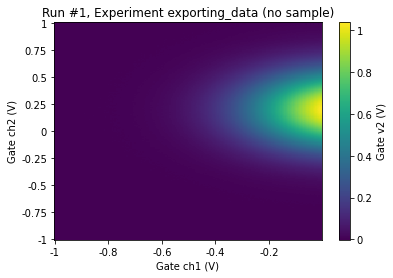

In [6]:
plot_dataset(qc_dataset)

Let's export this dataset into a netcdf file:

In [7]:
qc_dataset.export("netcdf", path=".")

In [8]:
qc_dataset.export_info

ExportInfo(export_paths={'nc': 'c:\\Users\\miastafe\\PycharmProjects\\Qcodes\\docs\\examples\\DataSet\\qcodes_1_aaaaaaaa-0000-0000-0000-017d6d0de1ba.nc'})

## Importing a netcdf file into QCoDeS database

First, let's load the netcdf file that we created above into an ``xarray`` ``DataSet``:

In [9]:
xr_dataset = xr.load_dataset(
    qc_dataset.export_info.export_paths["nc"],
    engine="h5netcdf"  # important!
)

In [10]:
xr_dataset

<xarray.Dataset>
Dimensions:  (dac_ch1: 200, dac_ch2: 201)
Coordinates:
  * dac_ch1  (dac_ch1) float64 -1.0 -0.995 -0.99 -0.985 ... -0.015 -0.01 -0.005
  * dac_ch2  (dac_ch2) float64 -1.0 -0.99 -0.98 -0.97 ... 0.97 0.98 0.99 1.0
Data variables:
    dmm_v2   (dac_ch1, dac_ch2) float64 -0.0003394 0.0002197 ... 0.006475
Attributes: (12/14)
    captured_counter:         1
    captured_run_id:          1
    completed_timestamp:      2021-11-29 19:56:12
    completed_timestamp_raw:  1638212172.8269236
    ds_name:                  results
    exp_name:                 exporting_data
    ...                       ...
    run_description:          {"version": 3, "interdependencies": {"paramspec...
    run_id:                   1
    run_timestamp:            2021-11-29 19:56:06
    run_timestamp_raw:        1638212166.0879848
    sample_name:              no sample
    snapshot:                 {"station": {"instruments": {"dmm": {"functions...

The first step is to create an experiment with the experiment name and sample name. Let's assume that those are available as attributes on the given xarray DataSet, but if that is not the case for you, just make sure to specify those correctly.

In [11]:
exp = load_or_create_experiment(
    experiment_name=xr_dataset.exp_name,
    sample_name=xr_dataset.sample_name
)
exp

exporting_data#no sample#1@c:\Users\miastafe\PycharmProjects\Qcodes\docs\examples\DataSet\export_example.db
-----------------------------------------------------------------------------------------------------------
1-results-1-dac_ch1,dac_ch2,dmm_v2-40200

Now let's create a measurement. For this we will use the already created (or loaded) experiment, and we'll use the "dataset name" that similarly to experiment and sample names might be available as attribute on the xarray dataset as ``ds_name`` (QCoDeS convention) or not.

In [12]:
meas = Measurement(
    exp=exp,
    name=xr_dataset.get("ds_name", "results")
)
meas

Now we need to extract the information about all the parameters in the dataset: independent, dependent, and standalones. Moreover, we will extract the shape information. The below code does all of this by inspecting the xarray DataSet. Note that it also tries to detect ``paramtype``/``label``/``unit`` for each parameter based on attributes that are available in the individual DataArrays in the xarray DataSet.

If some of your data is complex-valued, then make sure to adapt the code below to set ``paramtype`` for that data to ``"complex"``.

In [13]:
from qcodes.dataset.descriptions.param_spec import ParamSpecBase
from qcodes.dataset.descriptions.dependencies import InterDependencies_

def paramspec_from_datarray(name, dataarray):
    return ParamSpecBase(
        name=name,
        paramtype=dataarray.attrs.get("paramtype", "array"),
        label=dataarray.attrs.get("label", dataarray.attrs.get("long_name")),
        unit=dataarray.attrs.get("unit", dataarray.attrs.get("units"))
    )

shapes = {}

deps = {}
used_indeps = set()
for data_var_name, data_var in xr_dataset.data_vars.items():
    data_var_ps = paramspec_from_datarray(data_var_name, data_var)
    coords = tuple(
        paramspec_from_datarray(coord_name, coord)
        for coord_name in data_var.dims
        for coord in (data_var.coords[coord_name],)
    )
    deps[data_var_ps] = coords
    used_indeps.update(ps.name for ps in coords)
    shapes[data_var_ps.name] = data_var.shape

standalones = tuple(
    paramspec_from_datarray(coord_name, coord)
    for coord_name, coord in xr_dataset.coords.items()
    if coord_name not in xr_dataset.data_vars and coord_name not in used_indeps
)

interdeps = InterDependencies_(
    dependencies=deps,
    inferences=None,
    standalones=standalones,
)

if len(shapes) == 0:
    shapes = None

interdeps, shapes

(InterDependencies_(dependencies={ParamSpecBase('dmm_v2', 'numeric', 'Gate v2', 'V'): (ParamSpecBase('dac_ch1', 'numeric', 'Gate ch1', 'V'), ParamSpecBase('dac_ch2', 'numeric', 'Gate ch2', 'V'))}, inferences={}, standalones=frozenset()),
 {'dmm_v2': (200, 201)})

If the resulting interdependecies and shapes look correct you, then let's store them in the measurement object:

In [14]:
# qcodes developers will probably add an method to
# the measurement so that interdependencies can be
# provided as an object, next to the usual
# register_parameter method.
meas._interdeps = interdeps

In [15]:
if shapes is not None:
    meas.set_shapes(shapes)

Last but note least we need to extract the raw data from the xarray DataSet and pass that to qcodes via the measurement context manager. We will first collect the dependent parameters by their common independent parameters:

In [16]:
from collections import defaultdict

deps_by_indeps = defaultdict(set)
for dep, indep_tuple in interdeps.dependencies.items():
    deps_by_indeps[indep_tuple].add(dep)

deps_by_indeps = dict(deps_by_indeps)
deps_by_indeps

{(ParamSpecBase('dac_ch1', 'numeric', 'Gate ch1', 'V'),
  ParamSpecBase('dac_ch2', 'numeric', 'Gate ch2', 'V')): {ParamSpecBase('dmm_v2', 'numeric', 'Gate v2', 'V')}}

And now we will use that to extract raw data from the xarray DataSet and ravel it for qcodes measurement context manager to consume. Note that we will broadcast the independent parameters in order to have a ``numpy.meshgrid`` equivalent.

In [17]:
results_to_add = []

for indep_tuple, deps in deps_by_indeps.items():
    result = [
        (dep.name, np.ravel(xr_dataset.data_vars[dep.name].values))
        for dep in deps
    ]

    result.extend([
        (ind_name, np.ravel(ind.values))
        for ind_name, ind in zip(
            (ind_ps.name for ind_ps in indep_tuple),
            xr.broadcast(*(xr_dataset.coords[ind_ps.name] for ind_ps in indep_tuple))
        )
    ])

    results_to_add.append(result)

results_to_add

[[('dmm_v2',
   array([-0.00033944,  0.00021971, -0.00017336, ...,  0.00815157,
           0.00724429,  0.00647482])),
  ('dac_ch1', array([-1.   , -1.   , -1.   , ..., -0.005, -0.005, -0.005])),
  ('dac_ch2', array([-1.  , -0.99, -0.98, ...,  0.98,  0.99,  1.  ]))]]

If the results look correct, then we can add them using the measurement context manager with a DataSaver:

In [18]:
with meas.run() as datasaver:
    new_qc_dataset = datasaver.dataset

    for result in results_to_add:
        datasaver.add_result(*result)


Starting experimental run with id: 2. 


Done! Let's plot the new dataset to ensure that all the data was added correctly:

([<AxesSubplot:title={'center':'Run #2, Experiment exporting_data (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
 [<matplotlib.colorbar.Colorbar at 0x1f296ce4608>])

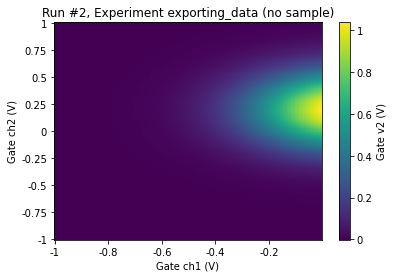

In [19]:
plot_dataset(new_qc_dataset)

And here's the plot of the original dataset:

([<AxesSubplot:title={'center':'Run #1, Experiment exporting_data (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
 [<matplotlib.colorbar.Colorbar at 0x1f296858288>])

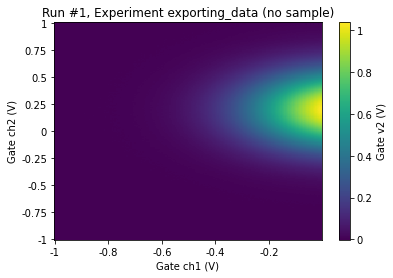

In [20]:
plot_dataset(qc_dataset)